In [1]:
import numpy as np
import xmlTranslator as xmlT
from ipywidgets import FloatProgress
from tqdm import tqdm
import importlib
from utils import get_project_root

TODO: 
- Repeat the sequences 3 times
- Extend all chords into the chromatic scale
- Complete the voicing as a MIDI array 
- Fix the style token
- Split into train and test
- Pass the MIDI into Embeddings

In [2]:
directory = '/data/iRealXML'
root = get_project_root()
myPath = str(root) + str(directory)

theChordDataset, theDurationsDataset, all_meta = xmlT.parse_info_from_XML(myPath)

  0%|          | 0/4007 [00:00<?, ?it/s]

(4006,) (4006,) (4006,)


In [3]:
def print_this_song(meta, dataset, id):
    print(meta[id])
    for i, e in enumerate(dataset[id]):
        print(i, e)
    print('')

In [3]:
#Correct the location of 'e||'
dataset = []
dataset_durations = []
for i, song in enumerate(theChordDataset):
    d = theDurationsDataset[i]
    song, durations = xmlT.correct_coda_end(song, d)
    dataset.append(song)
    dataset_durations.append(durations)
print(len(dataset), len(dataset_durations))

4006 4006


In [5]:
id = 204
print(all_meta[id])
print(len(dataset[id]))
print(dataset[id].tolist())

{'composer': 'Israel Houghton', 'style': 'Worship', 'song_name': 'Alpha And Omega', 'tonality': 'Db major', 'midi_key': 13, 'time_signature': '4/4', 'decade': 'Null'}
134
['<style>', 'Worship', 'Form_A', '|:', '.', 'Db', 'major', '|', '.', 'Ab', 'major', '/', 'C', '.', 'Db', 'major', '.', 'Eb', 'minor-seventh', '|', '.', 'Db', 'major', '.', 'Db', 'major', '/', 'F', '|', '.', 'Gb', 'major', '.', 'Eb', 'minor', '/', 'Gb', '.', 'Eb', 'minor', '|', '.', 'Db', 'major', '/', 'Ab', '.', 'Db', 'major', '/', 'Ab', '.', 'Bb', 'minor', '/', 'Ab', '|', '.', 'Ab', 'major', '.', 'Bb', 'minor', '.', 'Ab', 'major', '/', 'C', '|', '.', 'Db', 'major', '.', 'C', 'minor-seventh', 'alter b5', '.', 'F', 'dominant', 'Form_B', '|', '.', 'Bb', 'minor', '|', '.', 'Ab', 'major', '.', 'Gb', 'major', '|', '.', 'Db', 'major', '/', 'F', '|', '.', 'Gb', 'major', '.', 'Eb', 'minor', '/', 'Gb', '.', 'Eb', 'minor', '|', '.', 'Db', 'major', '/', 'Ab', '|', '.', 'Ab', 'major', '.', 'Bb', 'minor', '.', 'Ab', 'major', '/', 

In [4]:
'''
This section expands the song following the rules of bar repetitions and coda endings
'''
importlib.reload(xmlT)

id = 4
expand_form_dataset = []
expand_duration_dataset = []
status = True
for i in tqdm(range(len(dataset))):
    song_structure, duration_structure, status = xmlT.expand_song_structure(dataset[i], dataset_durations[i], i, False)
    if status == False:
        print('Song:', all_meta[i])
        id = i
        break
    song_structure = np.array(song_structure)
    duration_structure = np.array(duration_structure)
    expand_form_dataset.append(song_structure)
    expand_duration_dataset.append(duration_structure)

#Check if the dataset is correct
for i in range(len(expand_form_dataset)):
    if len(expand_form_dataset[i]) != len(expand_duration_dataset[i]):
        print('Error in:', i)
        break

  0%|          | 0/4006 [00:00<?, ?it/s]

100%|██████████| 4006/4006 [00:01<00:00, 2599.62it/s]


In [7]:
id = 5
test_this = dataset[id]
durations = dataset_durations[id]
print(test_this)

song, duration, status = xmlT.expand_song_structure(test_this, durations, id, True)

print(song)

['<style>' 'Funk' '|:' '.' 'C' 'major' '.' 'C' 'major' '/' 'E' '|' '.' 'F'
 'major' '|' '.' 'C' 'major' '.' 'C' 'major' '/' 'E' '|' 'Repeat_1' '.'
 'F' 'major' ':|' '|' 'Repeat_2' '.' 'F' 'major' '.' 'F#' 'dominant'
 'Form_A' '|' '.' 'G' 'dominant-13th' '|' '.' 'F' 'dominant-ninth' '|' '.'
 'G' 'dominant-13th' '|' '.' 'F' 'dominant-ninth' '|' '.' 'G'
 'dominant-13th' '|' '.' 'F' 'dominant-ninth' 'Form_B' '|' '.' 'C' 'major'
 '.' 'C' 'major' '/' 'E' '|' '.' 'F' 'major' '|' '.' 'C' 'major' '.' 'C'
 'major' '/' 'E' '|' '.' 'F' 'major' '.' 'F#' 'dominant' 'Form_A' '|' '.'
 'G' 'dominant-13th' '|' '.' 'F' 'dominant-ninth' '|' '.' 'G'
 'dominant-13th' '|' '.' 'F' 'dominant-ninth' '|' '.' 'G' 'dominant-13th'
 '|' '.' 'F' 'dominant-ninth' '.' 'C' 'none' 'Form_B' '|:' '.' 'C' 'major'
 '.' 'C' 'major' '/' 'E' '|' '.' 'F' 'major' '|' '.' 'C' 'major' '.' 'C'
 'major' '/' 'E' '|' '.' 'F' 'major' ':|' 'Form_C' '|' '.' 'E' 'major' '|'
 '.' 'A' 'minor-seventh' '|' '.' 'D' 'dominant' '|' '.' 'F' 'domin

In [5]:
#Replace the 'e||' with '|' and 'b||' with '|'
for i, song in enumerate(expand_form_dataset):
    for j, e in enumerate(song):
        if e == 'e||':
            expand_form_dataset[i][j] = '|'
        elif e == 'b||':
            expand_form_dataset[i][j] = '|'
            


In [9]:
sub_sections = dataset[4005:4006]
sub_durations = dataset_durations[4005:4006]
for i in range(len(sub_sections)):
    a,b,s = xmlT.expand_song_structure(sub_sections[i], sub_durations[i], i, True)
print(a)

Song: 0 
Length of sequence: 232
First coda passed at: 134
Moved to Head from 173 0
Second time goes to Coda at: 173
Process completed successfully.. New form length: 366
-----------------------------

['<style>', 'Ballad', 'Form_A', '|', '.', 'C', 'major', '.', 'E', 'minor', '/', 'B', '|', '.', 'B', 'suspended-fourth', '.', 'B', 'major', '.', 'B', 'major', '/', 'A', '|', '.', 'G', 'major', '.', 'C', 'major-seventh', '|', '.', 'C#', 'minor-seventh', 'alter b5', '.', 'G', 'major-seventh', '/', 'D', '|', '.', 'D', 'major', '/', 'F#', '.', 'C', 'major', '/', 'E', '|', '.', 'C', 'minor', '/', 'Eb', '.', 'G', 'major', '/', 'D', '|', '.', 'C#', 'minor-seventh', 'alter b5', '.', 'F#', 'dominant', '/', 'C#', '|', '.', 'B', 'major', '.', 'A', 'minor-seventh', '.', 'D', 'dominant', '/', 'A', 'Form_B', '|', '.', 'G', 'major', 'add 9', '.', 'D', 'major', '/', 'F#', '|', '.', 'C', 'major-seventh', '/', 'E', '.', 'C#', 'minor-seventh', 'alter b5', '|', '.', 'G', 'major', '/', 'D', '.', 'B', 'dominan

In [6]:
'''
Unify chord and duration into a tuple as good friends
'''

dataset = []
for chords_values, durations_values in zip(expand_form_dataset, expand_duration_dataset):
    coupled = list(zip(chords_values, durations_values))
    dataset.append(coupled)    

In [7]:
#correct the wrong chords
importlib.reload(xmlT)

corrected_sequence = xmlT.replaceTheseChords(dataset, False)

  0%|          | 0/4006 [00:00<?, ?it/s]

In [8]:
#Add the maj token to those single notes that are not clarified.
import voicing as vc
voicing = vc.Voicing()
new_dataset = []
id = 256
#id = 2686
name = all_meta[id]['song_name']

print(name)

for x, song in enumerate(tqdm(corrected_sequence)):
    sequence = []
    for i, item in enumerate(song):
        sequence.append(item)
        chord = item[0]
        duration = item[1]
        next = ''
        if i < len(song) - 1:
            next = song[i + 1][0]
            previous = song[i - 1][0]
            if chord in voicing.all_notes and next != 'N.C.' and previous != '/' and (next in voicing.structural_elements or next.startswith('Form_')):
                sequence.append(('maj', duration))
                #print(x, 'Added Maj to:', chord, 'at position:', i)
        elif i == len(song) - 1:
            previous = song[i - 1][0]
            if chord in voicing.all_notes and previous != '/':
                sequence.append(('maj', duration))
                #print(x, 'Added Maj to:', chord, 'at position:', i)
    new_dataset.append(sequence)
    
# for e in new_dataset:
#     for a in e:
#         print(a)

And What If I Don't


100%|██████████| 4006/4006 [00:01<00:00, 3977.48it/s]


In [9]:
#clean the elements that are ''
dataset = [[tup for tup in inner_list if tup[0] != ''] for inner_list in new_dataset]

print(len(dataset))
print(dataset[0])

for song in dataset:
    for i, e in enumerate(song):
        if e[0] == '':
            print(song)
            print(i)
            break

4006
[('<style>', 0.0), ('Medium Swing', 0.0), ('|', 0.0), ('.', 4.0), ('Eb', 4.0), ('maj', 4.0), ('|', 4.0), ('.', 4.0), ('Eb', 4.0), ('maj', 4.0), ('|', 4.0), ('.', 4.0), ('E', 4.0), ('o', 4.0), ('|', 4.0), ('.', 4.0), ('E', 4.0), ('o', 4.0), ('|', 4.0), ('.', 4.0), ('F', 4.0), ('m7', 4.0), ('|', 4.0), ('.', 4.0), ('Bb', 4.0), ('dom7', 4.0), ('|', 4.0), ('.', 4.0), ('Eb', 4.0), ('maj', 4.0), ('|', 4.0), ('.', 4.0), ('Eb', 4.0), ('maj', 4.0), ('|', 0.0), ('.', 4.0), ('Eb', 4.0), ('maj', 4.0), ('|', 4.0), ('.', 4.0), ('Eb', 4.0), ('maj', 4.0), ('|', 4.0), ('.', 4.0), ('E', 4.0), ('o', 4.0), ('|', 4.0), ('.', 4.0), ('E', 4.0), ('o', 4.0), ('|', 4.0), ('.', 4.0), ('F', 4.0), ('m7', 4.0), ('|', 4.0), ('.', 4.0), ('Bb', 4.0), ('dom7', 4.0), ('|', 4.0), ('.', 4.0), ('Eb', 4.0), ('maj', 4.0), ('|', 4.0), ('.', 2.0), ('A', 2.0), ('m7', 2.0), ('.', 2.0), ('D', 2.0), ('dom7', 2.0), ('|', 2.0), ('.', 4.0), ('G', 4.0), ('maj', 4.0), ('|', 4.0), ('.', 2.0), ('A', 2.0), ('m7', 2.0), ('.', 2.0), ('D

In [10]:
'''
This section is important to define a more concise format and tokenization.
Fix the format of extensions to avoid repeated elements
'''

xmlT.fix_extensions(dataset)

  0%|          | 0/4006 [00:00<?, ?it/s]

In [11]:
#Check vocabulary
chords_array = [[item[0] for item in row] for row in dataset]
concatenated_array = np.hstack(chords_array) 
vocab = set(concatenated_array)

print(len(vocab))
print(np.array(vocab))

200
{'Slowly', 'Pop', 'Funk', '128 Feel', 'Form_B', 'Fusion', 'Soul', 'F', 'Form_intro', 'Repeat_1', 'Bolero-Cha', 'Electric Blues', 'March', 'Baião', 'Gary Aprile', 'Rock Pop', 'D#', 'Slow Shuffle', 'G', "Even 8th's", 'Medium Waltz', 'Worship', 'Rock/Hip Hop', 'Rock/Reggae', 'A#', 'Samba Enredo', 'Gypsy Swing', 'Musical', 'Pop Rock', 'Form_verse', 'Samba', 'Latin-Swing', 'add #11', 'Hymn', 'A', 'm6', 'Blues Shuffle', '|', 'Waltz', 'UP Swing', 'Gypsy Bossa', 'Blues', 'Funk Jazz', 'Pop Ballad', 'Bolero-Son', 'Up Swing', 'alter #5', 'Mambo', 'Eb', 'Ballad', 'maj6', 'sus7', 'Pop Shuffle', 'Reggae', 'Samba-Rock', 'Medium Up', '.', 'Up Samba', 'Ab', 'alter #11', 'Pop-Shuffle', 'Maxixe', 'Country Blues', 'Up Tempo', 'E', 'Gb', 'Disco', 'Form_Coda', 'o7', 'Pop Folk', 'Bossa Acoustic', 'Afoxe', 'Up Waltz (One Feel)', 'Foxtrot', 'Afro-Samba', 'F#', 'Form_Segno', 'Samba-Funk', 'aug', 'C', 'Shuffle', 'Medium Shuffle', 'Fast Swing', 'Fast Blues', 'Moderate Latin', 'm7', 'add 11', 'Folk Rock', 'Roc

In [12]:
'''
Find duplicated 'add' or 'alter' elements and remove them to clean the tokenization method
'''

def correctDuplicatedExtensions(sequence):
    structural_elements = {'.', '|', ':|', '|:', '/', 'N.C.'}

    for x, song in enumerate(tqdm(sequence)):
        for y, item in enumerate(song):
            e = item[0]
            if '.' in e:
                search = True
                stepper = y + 2
                check_extensions = []
                while search:
                    if (stepper) >= len(song):
                        search = False
                        #print('End of song')
                        break
                    elif stepper < len(song) - 1:
                        element = song[stepper][0]
            
                    if element in structural_elements or element.startswith('Form_'):
                        search = False
                    else:
                        if element not in check_extensions:
                            check_extensions.append(element)
                        elif stepper < len(song)-1:
                            #print('Duplicated:', x, stepper, element, check_extensions)
                            song.pop(stepper)
                        stepper += 1
                if len(check_extensions) > 2:
                    continue
                    print(x, y+stepper, check_extensions)
                
correctDuplicatedExtensions(dataset)
id = 0
strings_array = [item[0] for item in dataset[id] if item[0] != '']
print(strings_array)

  0%|          | 0/4006 [00:00<?, ?it/s]

100%|██████████| 4006/4006 [00:00<00:00, 10665.65it/s]

['<style>', 'Medium Swing', '|', '.', 'Eb', 'maj', '|', '.', 'Eb', 'maj', '|', '.', 'E', 'o', '|', '.', 'E', 'o', '|', '.', 'F', 'm7', '|', '.', 'Bb', 'dom7', '|', '.', 'Eb', 'maj', '|', '.', 'Eb', 'maj', '|', '.', 'Eb', 'maj', '|', '.', 'Eb', 'maj', '|', '.', 'E', 'o', '|', '.', 'E', 'o', '|', '.', 'F', 'm7', '|', '.', 'Bb', 'dom7', '|', '.', 'Eb', 'maj', '|', '.', 'A', 'm7', '.', 'D', 'dom7', '|', '.', 'G', 'maj', '|', '.', 'A', 'm7', '.', 'D', 'dom7', '|', '.', 'G', 'maj', '|', '.', 'A', 'm7', '.', 'D', 'dom7', '|', '.', 'G', 'm7', '|', '.', 'C', 'dom7', '|', '.', 'F', 'dom7', '|', '.', 'Bb', 'dom7', '|', '.', 'Eb', 'maj', '|', '.', 'Eb', 'maj', '|', '.', 'Gb', 'o', '|', '.', 'Gb', 'o', '|', '.', 'F', 'm7', '|', '.', 'Bb', 'dom7', '|', '.', 'Eb', 'maj', '|', '.', 'Eb', 'maj', '|', '|', '.', 'G', 'm7', '|', '.', 'C', 'dom7', '|', '.', 'F', 'm7', '|', '.', 'Bb', 'dom7', '|', '.', 'Eb', 'maj', '|', '.', 'Eb', 'maj']


In [14]:
'''
These sequences have some elements that are repeated and should be removed
In particular the error of double nature Dom7 and sus
If the code is run twice, no print should be shown
'''
import voicing as vc

def correctThis(sequence):
    fix_this = [{'seq': ['dom7', 'sus7', 'add b9'], 'remove': 'dom7'},
                {'seq': ['sus4', 'add 7', 'dom7'], 'remove': 'dom7'},
                {'seq': ['dom7', 'sus4', 'add b9'], 'remove': 'dom7'},
                {'seq': ['sus7', 'add 13', 'sus4'], 'remove': 'sus4'},
                {'seq': ['sus7', 'add 9', 'sus4'], 'remove': 'sus4'},
                {'seq': ['dom7', 'add 13', 'sus7'], 'remove': 'sus7'},
                {'seq': ['dom7', 'add 13', 'sus4'], 'remove': 'sus4'},
                {'seq': ['dom7', 'add 9', 'sus7'], 'remove': 'sus7'},
                {'seq': ['dom7', 'add 9', 'add #5', 'add b9'], 'remove': 'add 9'},
                {'seq': ['m', 'add 6', 'add 9', 'sus4'], 'remove': 'sus4'},
                {'seq': ['sus7', 'add 13', 'sus4', 'add b9'], 'remove': 'sus4'},
                {'seq': ['dom7', 'add 13', 'sus4', 'add b9'], 'remove': 'sus4'}]

    structural_elements = vc.Voicing().getStructuralElements()

    for x, song in enumerate(sequence):
        for y, e in enumerate(song):
            if '.' in e[0]:
                search = True
                stepper = y + 2
                check_extensions = []
                while search:
                    if (stepper) >= len(song):
                        search = False
                        #print('End of song')
                        break
                    elif stepper < len(song) - 1:
                        element = song[stepper][0]
            
                    if element in structural_elements or element.startswith('Form_'):
                        search = False
                    else:
                        if element not in check_extensions:
                            check_extensions.append(element)
                        for item in fix_this:
                            if check_extensions == item['seq']:
                                print(x, stepper, check_extensions, 'to remove:', item['remove'])
                                #find the location of the element in the array
                                for i in range(len(check_extensions)):
                                    if check_extensions[i] == item['remove']:
                                        location = i + stepper - 2
                                        #erase this element from song
                                        if location < len(song):
                                            print(location, item['remove'], song[location])
                                            song.pop(location)
                                        break
                                
                        stepper += 1

#this has to be run three times to clean the dataset
for i in range(4):
    correctThis(dataset)


In [15]:
'''
Correct duplicated natures using Dom7 and suspended
'''

for x, song in enumerate(dataset):
    for y, element in enumerate(song):
        info = element[0]
        if info == '.' and y < len(song) - 1:
            z = y + 1
            next = song[z][0]
            
            found_dom = False
            found_sus = False
            seq = []
            while z < len(song) - 1 and next != '.':
                if 'dom7' in next:
                    dom = (next, z)
                    seq.append(dom)
                    found_dom = True
                if next.startswith('sus'):
                    found_sus = True
                    sus = (next, z)
                    seq.append(sus)
                if found_dom and found_sus:
                    print("Corrected at:", x, y, seq)
                    duration = song[y][1]
                    corrected = ('sus7', duration)
                    c_id = seq[0][1]
                    song[c_id] = corrected
                    delete_id = seq[1][1]
                    song.pop(delete_id)
                    #closeThis = True
                    break
                z += 1
                next = song[z][0]
                
                

Corrected at: 1873 199 [('dom7', 201), ('sus7', 202)]
Corrected at: 2082 225 [('dom7', 227), ('sus7', 228)]
Corrected at: 2238 266 [('dom7', 268), ('sus7', 269)]
Corrected at: 2238 271 [('dom7', 273), ('sus7', 274)]
Corrected at: 2238 540 [('dom7', 542), ('sus7', 543)]
Corrected at: 2238 545 [('dom7', 547), ('sus7', 548)]
Corrected at: 2547 356 [('dom7', 358), ('sus4', 360)]
Corrected at: 2689 125 [('dom7', 127), ('sus7', 128)]
Corrected at: 2689 242 [('dom7', 244), ('sus7', 245)]
Corrected at: 2689 407 [('dom7', 409), ('sus7', 410)]
Corrected at: 2689 454 [('dom7', 456), ('sus7', 457)]
Corrected at: 2689 572 [('dom7', 574), ('sus7', 575)]
Corrected at: 2689 675 [('dom7', 677), ('sus7', 678)]
Corrected at: 2865 201 [('dom7', 203), ('sus4', 205)]
Corrected at: 2866 198 [('dom7', 200), ('sus4', 202)]
Corrected at: 2866 203 [('dom7', 205), ('sus4', 207)]
Corrected at: 3090 273 [('dom7', 275), ('sus4', 277)]
Corrected at: 3090 338 [('dom7', 340), ('sus4', 342)]
Corrected at: 3236 155 [('do

In [16]:
'''
Correct duplicated natures 
'''

import voicing as vc
voicing = vc.Voicing()

for x, song in enumerate(dataset):
    for y, element in enumerate(song):
        info = element[0]
        if info == '.' and y < len(song) - 1:
            z = y + 1
            next = song[z][0]
            seq = []
            while z < len(song) - 1 and next != '.':
                if next in voicing.natures:
                    nat = (next, z)
                    seq.append(nat)
                    found_dom = True
                if len(seq) > 1:
                    print("Corrected at:", x, y, seq)
                    delete_id = seq[1][1]
                    song.pop(delete_id)
                    break
                z += 1
                next = song[z][0]

Corrected at: 2312 112 [('sus4', 114), ('sus7', 115)]
Corrected at: 2547 351 [('m7', 353), ('sus4', 354)]
Corrected at: 2865 197 [('maj7', 199), ('sus4', 200)]
Corrected at: 2866 194 [('maj7', 196), ('sus4', 197)]
Corrected at: 2866 207 [('maj7', 209), ('sus4', 210)]
Corrected at: 3034 24 [('sus4', 26), ('sus7', 27)]
Corrected at: 3034 52 [('sus4', 54), ('sus7', 55)]
Corrected at: 3236 160 [('m7', 162), ('sus4', 163)]
Corrected at: 3290 81 [('m7', 83), ('sus4', 84)]
Corrected at: 3290 177 [('m7', 179), ('sus4', 180)]
Corrected at: 3291 84 [('m7', 86), ('sus4', 87)]
Corrected at: 3524 151 [('sus4', 153), ('sus7', 154)]


In [20]:
id = 5
print(all_meta[id])

{'composer': 'Vulfpeck', 'style': 'Funk', 'song_name': '1612', 'tonality': 'C major', 'midi_key': 12, 'time_signature': '4/4', 'decade': 'Null'}


In [17]:
#Check the length of the song

max = {'v': 0, 'id': 0}
min = {'v': 1000, 'id': 0}

for i in range(len(dataset)):
    if len(dataset[i]) > max['v']:
        max['v'] = len(dataset[i])
        max['id'] = i
    if len(dataset[i]) < min['v']:
        min['v'] = len(dataset[i])
        min['id'] = i

print('Max:', max, 'Min:', min)

Max: {'v': 1393, 'id': 1119} Min: {'v': 31, 'id': 3331}


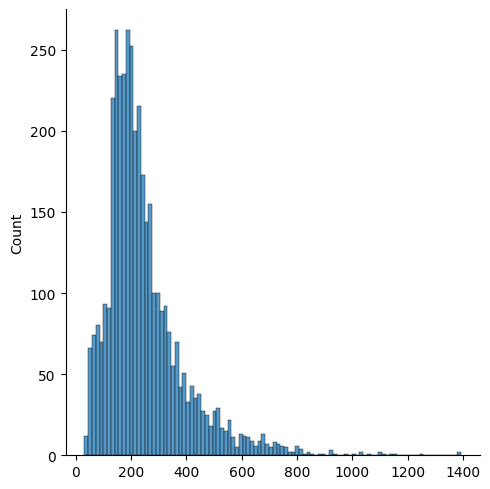

In [18]:
import seaborn as sns

#visualize the length of the songs

length = []
for song in dataset:
    length.append(len(song))
    
sns.displot(length, kde=False, bins=100)

In [23]:
import voicing as vc
voicing = vc.Voicing()

print(all_meta[4005]['song_name'])
id = 0
for i, data in enumerate(all_meta):
    if 'Giant Steps' in data['song_name']:
        id = i
        print(i)
        break

strings_array =  voicing.get_chords(dataset[id]) 
print(strings_array)


Message To A Friend
1474
['<style>', 'Up Tempo Swing', '|', '.', 'B', 'maj7', '.', 'D', 'dom7', '|', '.', 'G', 'maj7', '.', 'Bb', 'dom7', '|', '.', 'Eb', 'maj7', '|', '.', 'A', 'm7', '.', 'D', 'dom7', '|', '.', 'G', 'maj7', '.', 'Bb', 'dom7', '|', '.', 'Eb', 'maj7', '.', 'F#', 'dom7', '|', '.', 'B', 'maj7', '|', '.', 'F', 'm7', '.', 'Bb', 'dom7', '|', '.', 'Eb', 'maj7', '|', '.', 'A', 'm7', '.', 'D', 'dom7', '|', '.', 'G', 'maj7', '|', '.', 'C#', 'm7', '.', 'F#', 'dom7', '|', '.', 'B', 'maj7', '|', '.', 'F', 'm7', '.', 'Bb', 'dom7', '|', '.', 'Eb', 'maj7', '|', '.', 'C#', 'm7', '.', 'F#', 'dom7']


In [24]:
import voicing as vc

#check the voicing conversion of all chords
from_ = 4005
to_ = 4006
myTracks = dataset[from_:to_]
sub_names = []
for names in all_meta[from_:to_]:
    sub_names.append(names['song_name'])
voicing = vc.Voicing()
midi_voicing = []


i = 0
for item in tqdm(myTracks):
    mv, status = voicing.convert_chords_to_voicing(item)
    midi_voicing.append(mv)
    if status == False:
        print(i, '\n', all_meta[i], '\n', item)
        break
    i += 1
print(len(midi_voicing))
print(sub_names)


100%|██████████| 1/1 [00:00<00:00, 1709.87it/s]

1
['Message To A Friend']


In [19]:
''' 
Extend the form of the song to complete at least 64 bars
'''

bars = []
for song in dataset:
    number_of_bars = 0
    for i, e in enumerate(song):
        if e[0] == '|' or e[0] == 'e||' or e[0] == 'b||':
            number_of_bars += 1
    bars.append(number_of_bars)
    
print(len(bars))
print(bars)

repeat_times = 4
minimum = 64
new_dataset = []
for i, song in enumerate(dataset):
    new_song = []
    if bars[i] < minimum:
        #repeat the song again
        intro = song[0:2]
        s = song[2:]
        new_song = intro
        for i in range(repeat_times):
            new_song+=s
    
        new_dataset.append(new_song)
    else:
        new_dataset.append(song)

   

4006
[39, 41, 40, 37, 54, 72, 32, 45, 32, 33, 32, 53, 47, 33, 55, 20, 32, 30, 9, 36, 61, 42, 57, 28, 57, 32, 36, 9, 33, 50, 32, 32, 32, 32, 9, 64, 49, 38, 32, 79, 32, 29, 41, 68, 36, 13, 53, 36, 32, 24, 32, 22, 38, 32, 29, 44, 23, 32, 66, 68, 43, 33, 55, 53, 61, 28, 36, 32, 13, 23, 56, 32, 16, 36, 40, 28, 67, 33, 9, 32, 64, 26, 32, 32, 32, 74, 85, 68, 24, 47, 45, 45, 84, 40, 33, 48, 16, 26, 32, 32, 53, 40, 40, 32, 32, 32, 8, 35, 76, 76, 56, 56, 35, 43, 49, 125, 135, 93, 93, 54, 54, 55, 57, 52, 32, 32, 32, 74, 33, 92, 73, 32, 32, 32, 65, 65, 40, 40, 36, 33, 34, 167, 45, 32, 92, 32, 48, 32, 33, 40, 32, 93, 20, 20, 32, 48, 48, 10, 30, 32, 32, 40, 43, 24, 32, 32, 103, 32, 32, 37, 41, 53, 58, 52, 98, 36, 31, 32, 32, 53, 53, 32, 36, 34, 33, 52, 32, 64, 32, 96, 37, 37, 37, 44, 28, 36, 39, 39, 46, 44, 32, 34, 34, 32, 14, 68, 47, 47, 42, 42, 24, 24, 32, 49, 48, 24, 57, 49, 32, 31, 31, 32, 32, 21, 21, 41, 16, 63, 115, 38, 46, 52, 52, 51, 51, 65, 65, 59, 33, 43, 43, 46, 33, 36, 68, 69, 71, 71, 81

4006
[156, 164, 160, 148, 216, 72, 128, 180, 128, 132, 128, 212, 188, 132, 220, 80, 128, 120, 36, 144, 244, 168, 228, 112, 228, 128, 144, 36, 132, 200, 128, 128, 128, 128, 36, 64, 196, 152, 128, 79, 128, 116, 164, 68, 144, 52, 212, 144, 128, 96, 128, 88, 152, 128, 116, 176, 92, 128, 66, 68, 172, 132, 220, 212, 244, 112, 144, 128, 52, 92, 224, 128, 64, 144, 160, 112, 67, 132, 36, 128, 64, 104, 128, 128, 128, 74, 85, 68, 96, 188, 180, 180, 84, 160, 132, 192, 64, 104, 128, 128, 212, 160, 160, 128, 128, 128, 32, 140, 76, 76, 224, 224, 140, 172, 196, 125, 135, 93, 93, 216, 216, 220, 228, 208, 128, 128, 128, 74, 132, 92, 73, 128, 128, 128, 65, 65, 160, 160, 144, 132, 136, 167, 180, 128, 92, 128, 192, 128, 132, 160, 128, 93, 80, 80, 128, 192, 192, 40, 120, 128, 128, 160, 172, 96, 128, 128, 103, 128, 128, 148, 164, 212, 232, 208, 98, 144, 124, 128, 128, 212, 212, 128, 144, 136, 132, 208, 128, 64, 128, 96, 148, 148, 148, 176, 112, 144, 156, 156, 184, 176, 128, 136, 136, 128, 56, 68, 188, 188, 1

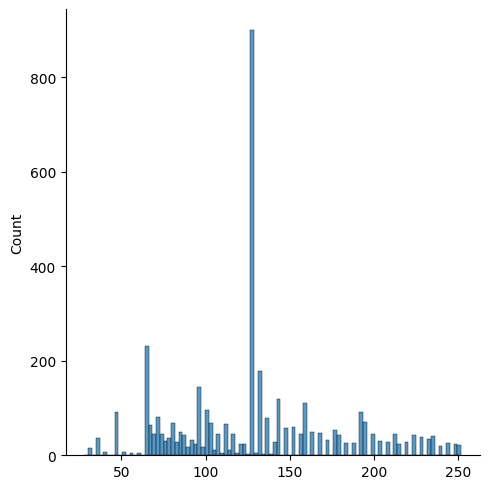

In [20]:
bars = []
for song in new_dataset:
    number_of_bars = 0
    for i, e in enumerate(song):
        if e[0] == '|' or e[0] == 'e||' or e[0] == 'b||':
            number_of_bars += 1
    bars.append(number_of_bars)
    
print(len(bars))
print(bars)

import seaborn as sns

#visualize the bars length of the songs
sns.displot(bars, kde=False, bins=100)

In [27]:
#check all tonalities
all_tonalities = [all_meta[i]['tonality'] for i in range(len(all_meta))]

all_tonalities = set(all_tonalities)
print(all_tonalities)

#get only the notes by splitting the tonalities
tonalities = [t.split(' ')[0] for t in all_tonalities]

#sort notes starting from A
tonalities = set(tonalities)
notes = sorted(tonalities, key=lambda x: (x, x[0]))
print(notes)


{'B major', 'Eb major', 'Ab major', 'G# minor', 'C minor', 'A major', 'Eb minor', 'F major', 'Bb major', 'E major', 'Bb minor', 'A minor', 'G minor', 'B minor', 'D major', 'Db major', 'C# minor', 'D minor', 'Gb major', 'E minor', 'F# minor', 'G major', 'F minor', 'C major'}
['A', 'Ab', 'B', 'Bb', 'C', 'C#', 'D', 'Db', 'E', 'Eb', 'F', 'F#', 'G', 'G#', 'Gb']


In [28]:
#Check songs after transposing test case

import transposition as tr

transpose = tr.Transposition()

#id = 1474
#id = 4005
id = 256
song_to_transpose = new_dataset[id]
tonality = all_meta[id]['tonality']
song_name = all_meta[id]['song_name']

print(song_to_transpose) 
tonal = 'C'
new_song = transpose.transpose_song(song_to_transpose, tonality, tonal)

print(len(song_to_transpose), len(new_song))

[('<style>', 0.0), ('Medium Swing', 0.0), ('Form_A', 0.0), ('|', 0.0), ('.', 2.0), ('Eb', 2.0), ('dom7', 2.0), ('.', 2.0), ('Bb', 2.0), ('dom7', 2.0), ('|', 2.0), ('.', 4.0), ('Eb', 4.0), ('dom7', 4.0), ('|', 4.0), ('.', 4.0), ('C', 4.0), ('m', 4.0), ('|', 4.0), ('.', 4.0), ('C', 4.0), ('m', 4.0), ('|', 4.0), ('.', 4.0), ('Eb', 4.0), ('dom7', 4.0), ('|', 4.0), ('.', 4.0), ('Ab', 4.0), ('dom7', 4.0), ('|', 4.0), ('.', 4.0), ('F', 4.0), ('m', 4.0), ('|', 4.0), ('.', 4.0), ('F', 4.0), ('m', 4.0), ('/', 4.0), ('Bb', 4.0), ('|', 0.0), ('.', 2.0), ('Eb', 2.0), ('dom7', 2.0), ('.', 2.0), ('Bb', 2.0), ('dom7', 2.0), ('|', 2.0), ('.', 4.0), ('Eb', 4.0), ('dom7', 4.0), ('|', 4.0), ('.', 4.0), ('C', 4.0), ('m', 4.0), ('|', 4.0), ('.', 4.0), ('C', 4.0), ('m', 4.0), ('|', 4.0), ('.', 4.0), ('Eb', 4.0), ('dom7', 4.0), ('|', 4.0), ('.', 4.0), ('Ab', 4.0), ('dom7', 4.0), ('|', 4.0), ('.', 2.0), ('F', 2.0), ('m', 2.0), ('.', 2.0), ('Bb', 2.0), ('dom7', 2.0), ('|', 2.0), ('.', 4.0), ('Eb', 4.0), ('dom7'

In [21]:
#Augment the dataset with all tonalities
import transposition as tr
transpose = tr.Transposition()

dataset_augmented = []
meta_augmented = []
tonalities = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']

for i, song in enumerate(tqdm(new_dataset)):
    tonality = all_meta[i]['tonality']
    for tonal in tonalities:
        new_song = transpose.transpose_song(song, tonality, tonal)
        dataset_augmented.append(new_song)
        all_meta[i]['tonality'] = tonal
        meta_augmented.append(all_meta[i])

print(len(dataset_augmented), len(meta_augmented))

100%|██████████| 4006/4006 [01:49<00:00, 36.61it/s]

48072 48072


In [67]:
#Extract all MIDI arrays from the dataset, check the sizes and normalize its size to eight values
import voicing as vc
importlib.reload(vc)
voicing = vc.Voicing()

midi_voicing_dataset = []
for i, song in enumerate(tqdm(dataset_augmented)):
    mv, status = voicing.convert_chords_to_voicing(song)
    midi_voicing_dataset.append(mv)
    if status == False:
        print(i, '\n', meta_augmented[i], '\n', song)
        break
    
print(len(midi_voicing_dataset))


100%|██████████| 48072/48072 [01:37<00:00, 493.94it/s] 

48072


In [66]:
#Check particular cases to be sure MIDI voicing translation is correct

#Reload voicing and check the error
import voicing as vc
importlib.reload(vc)
voicing = vc.Voicing()


seq = [('<style>', 4.0), ('Jazz', 4.0), ('|', 4.0), ('.', 4.0), ('Eb', 4.0), ('maj7', 4.0), ('add #11', 4.0), ('add 13', 4.0),('/', 4.0), ('D', 4.0)]

import voicing as vc
voicing = vc.Voicing()

id = 1
test_this = new_dataset[id]
name = all_meta[id]['song_name']

path = '../data/midi_files/'
midi_v, _ = voicing.convert_chords_to_voicing(seq)

print(name)
for i, e in enumerate(midi_v):
    print(e)
    
#print(midi_v)

#voicing.export_to_midi(midi_v, name, path)

'Tain't No Sin To Take Off Your Skin
([0, 0, 0, 0, 0, 0, 0, 0], 4.0, '<style>')
([0, 0, 0, 0, 0, 0, 0, 0], 4.0, 'Jazz')
([0, 0, 0, 0, 0, 0, 0, 0], 4.0, '|')
([0, 0, 0, 0, 0, 0, 0, 0], 4.0, '.')
([51, 0, 0, 0, 0, 0, 0, 0], 4.0, 'Eb')
([51, 62, 67, 70, 0, 0, 0, 0], 4.0, 'maj7')
([51, 62, 67, 70, 69, 0, 0, 0], 4.0, 'add #11')
([51, 62, 67, 70, 69, 72, 0, 0], 4.0, 'add 13')
([0, 0, 0, 0, 0, 0, 0, 27], 4.0, '/')
([50, 63, 62, 67, 70, 69, 72, 0], 4.0, 'D')


In [68]:
id = 3732
correct = True
for n, song in enumerate(tqdm(midi_voicing_dataset)):
    for i, e in enumerate(song):
        m = e[0]
        if len(m) != 8:
            print("\nWrong sequence at: ------> ", n, i, '\n', e, len(m), '\n')
            id = n
            print_this_song(meta_augmented, midi_voicing_dataset, id)
            correct = False
            break
    if correct == False:
        break
        
if (correct): print('Test Completed Successfully!!!')

100%|██████████| 48072/48072 [00:09<00:00, 4997.09it/s]

Test Completed Successfully!!!


In [69]:
id = 22872
print(meta_augmented[id])
print(dataset_augmented[id])
print(midi_voicing_dataset[id])

for i, chord in enumerate(dataset_augmented[id]):
    midi = midi_voicing_dataset[id][i][0]
    #print(i, chord, midi)

{'composer': 'Strayhorn-Ellington', 'style': 'Medium Swing', 'song_name': 'Isfahan', 'tonality': 'B', 'midi_key': 13, 'time_signature': '4/4', 'decade': 'Null'}
[('<style>', 0.0), ('Medium Swing', 0.0), ('Form_A', 0.0), ('|', 0.0), ('.', 4.0), ('C', 4.0), ('maj7', 4.0), ('|', 4.0), ('.', 2.0), ('A', 2.0), ('maj7', 2.0), ('.', 2.0), ('A', 2.0), ('dom7', 2.0), ('alter #5', 2.0), ('|', 2.0), ('.', 4.0), ('D', 4.0), ('dom7', 4.0), ('add 9', 4.0), ('|', 4.0), ('.', 4.0), ('D', 4.0), ('dom7', 4.0), ('add 9', 4.0), ('|', 4.0), ('.', 4.0), ('Ab', 4.0), ('maj7', 4.0), ('|', 4.0), ('.', 4.0), ('G', 4.0), ('dom7', 4.0), ('add 13', 4.0), ('add b9', 4.0), ('|', 4.0), ('.', 4.0), ('C', 4.0), ('maj7', 4.0), ('|', 4.0), ('.', 4.0), ('C', 4.0), ('maj7', 4.0), ('Form_B', 4.0), ('|', 4.0), ('.', 2.0), ('F#', 2.0), ('m7', 2.0), ('alter b5', 2.0), ('add b9', 2.0), ('.', 2.0), ('B', 2.0), ('dom7', 2.0), ('alter b5', 2.0), ('add b9', 2.0), ('|', 2.0), ('.', 4.0), ('E', 4.0), ('m6', 4.0), ('|', 4.0), ('.', 2.

In [71]:
id = 6845
name = meta_augmented[id]['song_name']
the_song = midi_voicing_dataset[id]


#mv, status = voicing.convert_chords_to_voicing(new_song)
voicing.export_to_midi(the_song, name)

song: Boogie Chillen No.2
MIDI file created! 
---------------------------------


In [72]:
#Save the files
import json

saveIt = False
if saveIt:
    with open('../data/formatted/meta_dataset.txt', 'w') as jsonFile:
        json.dump(meta_augmented, jsonFile)
        
    with open('../data/formatted/dataset_augmented.txt', 'w') as jsonFile:
        json.dump(dataset_augmented, jsonFile)
        
    with open('../data/formatted/midi_voicing_dataset.txt', 'w') as jsonFile:
        json.dump(midi_voicing_dataset, jsonFile)